In [3]:
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data_dir = os.path.join("..", "data")
sys.path.append(data_dir)

from EnglandWalesmeasles import data as engwal

distances = np.load(os.path.join("..", "data", "EnglandWalesdistances.npy"))

f"{np.__version__=}"

"np.__version__='1.26.4'"

In [4]:
EWdata = pd.DataFrame(
    [
        {"name": placename, "population": place.population[0], "latitude": place.latitude, "longitude": place.longitude}
        for placename, place in engwal.places.items()
    ]
)

In [5]:
EWdata[EWdata["name"].str.contains("London", case=False)]

,name,population,latitude,longitude
507,London,2462500,51.517,-0.105


In [6]:
EWdata["cases"] = EWdata["name"].apply(lambda name: engwal.places[name].cases)
EWdata["births"] = EWdata["name"].apply(lambda name: engwal.places[name].births)
EWdata["prop_zero"] = EWdata["cases"].apply(lambda x: np.mean(np.array(x) == 0))

In [7]:
EWdata.loc[507]["births"] / EWdata.loc[507]["population"]

array([0.0182136 , 0.01861523, 0.02681137, 0.02870457, 0.02469239,
       0.02296325, 0.02179086, 0.02127391, 0.02089056, 0.02070741,
       0.02060711, 0.02023391, 0.02118619, 0.02141442, 0.02199066,
       0.02241259, 0.02329665, 0.0243866 , 0.02539046, 0.0257868 ,
       0.0257868 ])

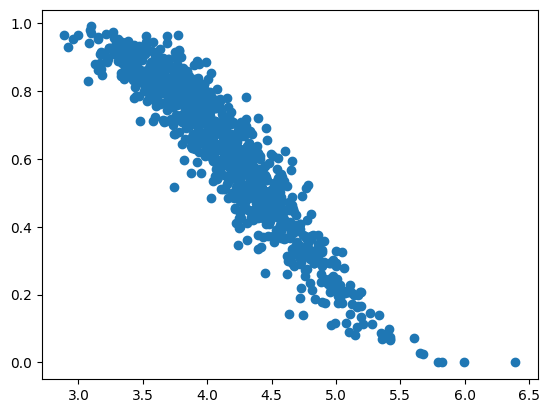

In [8]:
plt.plot(np.log10(EWdata["population"]), EWdata["prop_zero"], "o")

In [9]:
output_dir = os.path.join("..", "outputs3")
params = pd.read_csv(os.path.join(output_dir, "params.csv"))

results = []

for fname in range(100):
    with open(os.path.join(output_dir, "EWoutputs_gravity_" + str(fname) + ".pkl"), "rb") as f:
        x = pickle.load(f)
    # x.cases_test: shape (days, 954)
    cases_test = np.array(x.cases_test)
    incidence = np.array(x.incidence)
    populations = np.array(x.populations[0, :])
    # Aggregate daily to weekly: sum every 7 days along axis 0
    num_weeks = cases_test.shape[0] // 7
    weekly_cases = cases_test[: num_weeks * 7].reshape(num_weeks, 7, 954).sum(axis=1)
    weekly_incidence = incidence[: num_weeks * 7].reshape(num_weeks, 7, 954).sum(axis=1)
    # Create a DataFrame for this parameter set, matching EWdata's structure
    df = pd.DataFrame(
        {
            "name": EWdata["name"],
            "population": populations,
            "cases": list(weekly_cases.T),  # each entry is a list of weekly cases for that place
            "incidence": list(weekly_incidence.T),  # each entry is a list of weekly cases for that place
        }
    )
    df["k"] = params.iloc[fname]["k"]
    df["b"] = params.iloc[fname]["b"]
    df["c"] = params.iloc[fname]["c"]
    # df.set_index(["k", "a", "c", "name"], inplace=True)
    results.append(df)

In [10]:
for df_result in results:
    df_result["prop_zero"] = df_result["incidence"].apply(lambda x: np.mean(np.array(x[1040:]) == 0))
    df_result["prop_low"] = df_result["incidence"].apply(lambda x: np.mean(np.array(x[1040:]) <= 2))

In [11]:
from scipy.optimize import curve_fit


# 1. Define fitting functions for mean and variance
def logistic(x, x0, k):
    # Logistic function bounded between 0 and 1, transitions from 1 to 0 as x increases
    return 1 / (1 + np.exp(k * (x - x0)))


def fit_mean_var(x, y):
    # Fit a logistic to the mean
    # Initial guess: midpoint at median(x), width=1
    p0 = [np.median(x), 1.0]
    bounds = ([-np.inf, 0.01], [np.inf, 10.0])
    popt_mean, _ = curve_fit(logistic, x, y, p0=p0, bounds=bounds, maxfev=10000)
    return popt_mean


# 3. Define similarity metric (sum of squared differences of mean and variance fits)
def similarity_metric(mean_data, mean_sim):
    # Evaluate both curves on a common grid
    x_grid = np.linspace(2.5, 6.5, 200)
    data_curve = logistic(x_grid, *mean_data)
    sim_curve = logistic(x_grid, *mean_sim)
    # Similarity: sum of squared differences between the curves
    mean_diff = np.sum((sim_curve - data_curve) ** 2)
    return mean_diff


params = []
sim_metrics = []

for i, df_result in enumerate(results):
    # Plot observed and simulated data
    logpop_obs = np.log10(EWdata["population"])
    prop_zero_obs = EWdata["prop_zero"]
    logpop_sim = np.log10(df_result["population"])
    prop_zero_sim = df_result["prop_zero"]

    # Fit to observed
    popt_obs = fit_mean_var(logpop_obs, prop_zero_obs)
    popt_sim = fit_mean_var(logpop_sim, prop_zero_sim)
    # Similarity metric
    sim = similarity_metric(popt_obs, popt_sim)
    k = df_result["k"].iloc[0]
    a = df_result["b"].iloc[0]
    c = df_result["c"].iloc[0]
    params.append((k, a, c))
    sim_metrics.append(sim)

In [12]:
# Create a DataFrame with k, b, c, and similarity score, then sort by similarity
params_df = pd.DataFrame(params, columns=["k", "b", "c"])
params_df["similarity"] = sim_metrics
ranked_params = params_df.sort_values("similarity").reset_index(drop=True)
ranked_params[0:20]

,k,b,c,similarity
0,0.002563,0.361395,1.162004,0.020177
1,0.002334,0.345455,1.667455,0.050824
2,0.002402,0.504796,1.104515,0.058813
3,0.002463,0.415373,1.723733,0.065856
4,0.003511,0.428402,1.859881,0.157201
5,0.003139,0.464161,1.193515,0.168581
6,0.003320,0.401383,1.323752,0.181627
7,0.003353,0.503991,1.561033,0.255507
8,0.003398,0.618067,1.285311,0.284185
9,0.002704,0.719355,1.433169,0.295355


In [13]:
params_df

,k,b,c,similarity
0,0.010715,0.390482,1.986225,3.380539
1,0.002402,0.504796,1.104515,0.058813
2,0.006794,0.681441,1.422656,1.920747
3,0.008658,0.795398,1.875062,2.041468
4,0.022042,0.336826,1.584276,8.052248
...,...,...,...,...
95,0.014870,0.583684,1.287278,4.720921
96,0.003398,0.618067,1.285311,0.284185
97,0.024474,0.366421,1.697051,8.746272
98,0.012041,0.341354,1.955066,4.795889


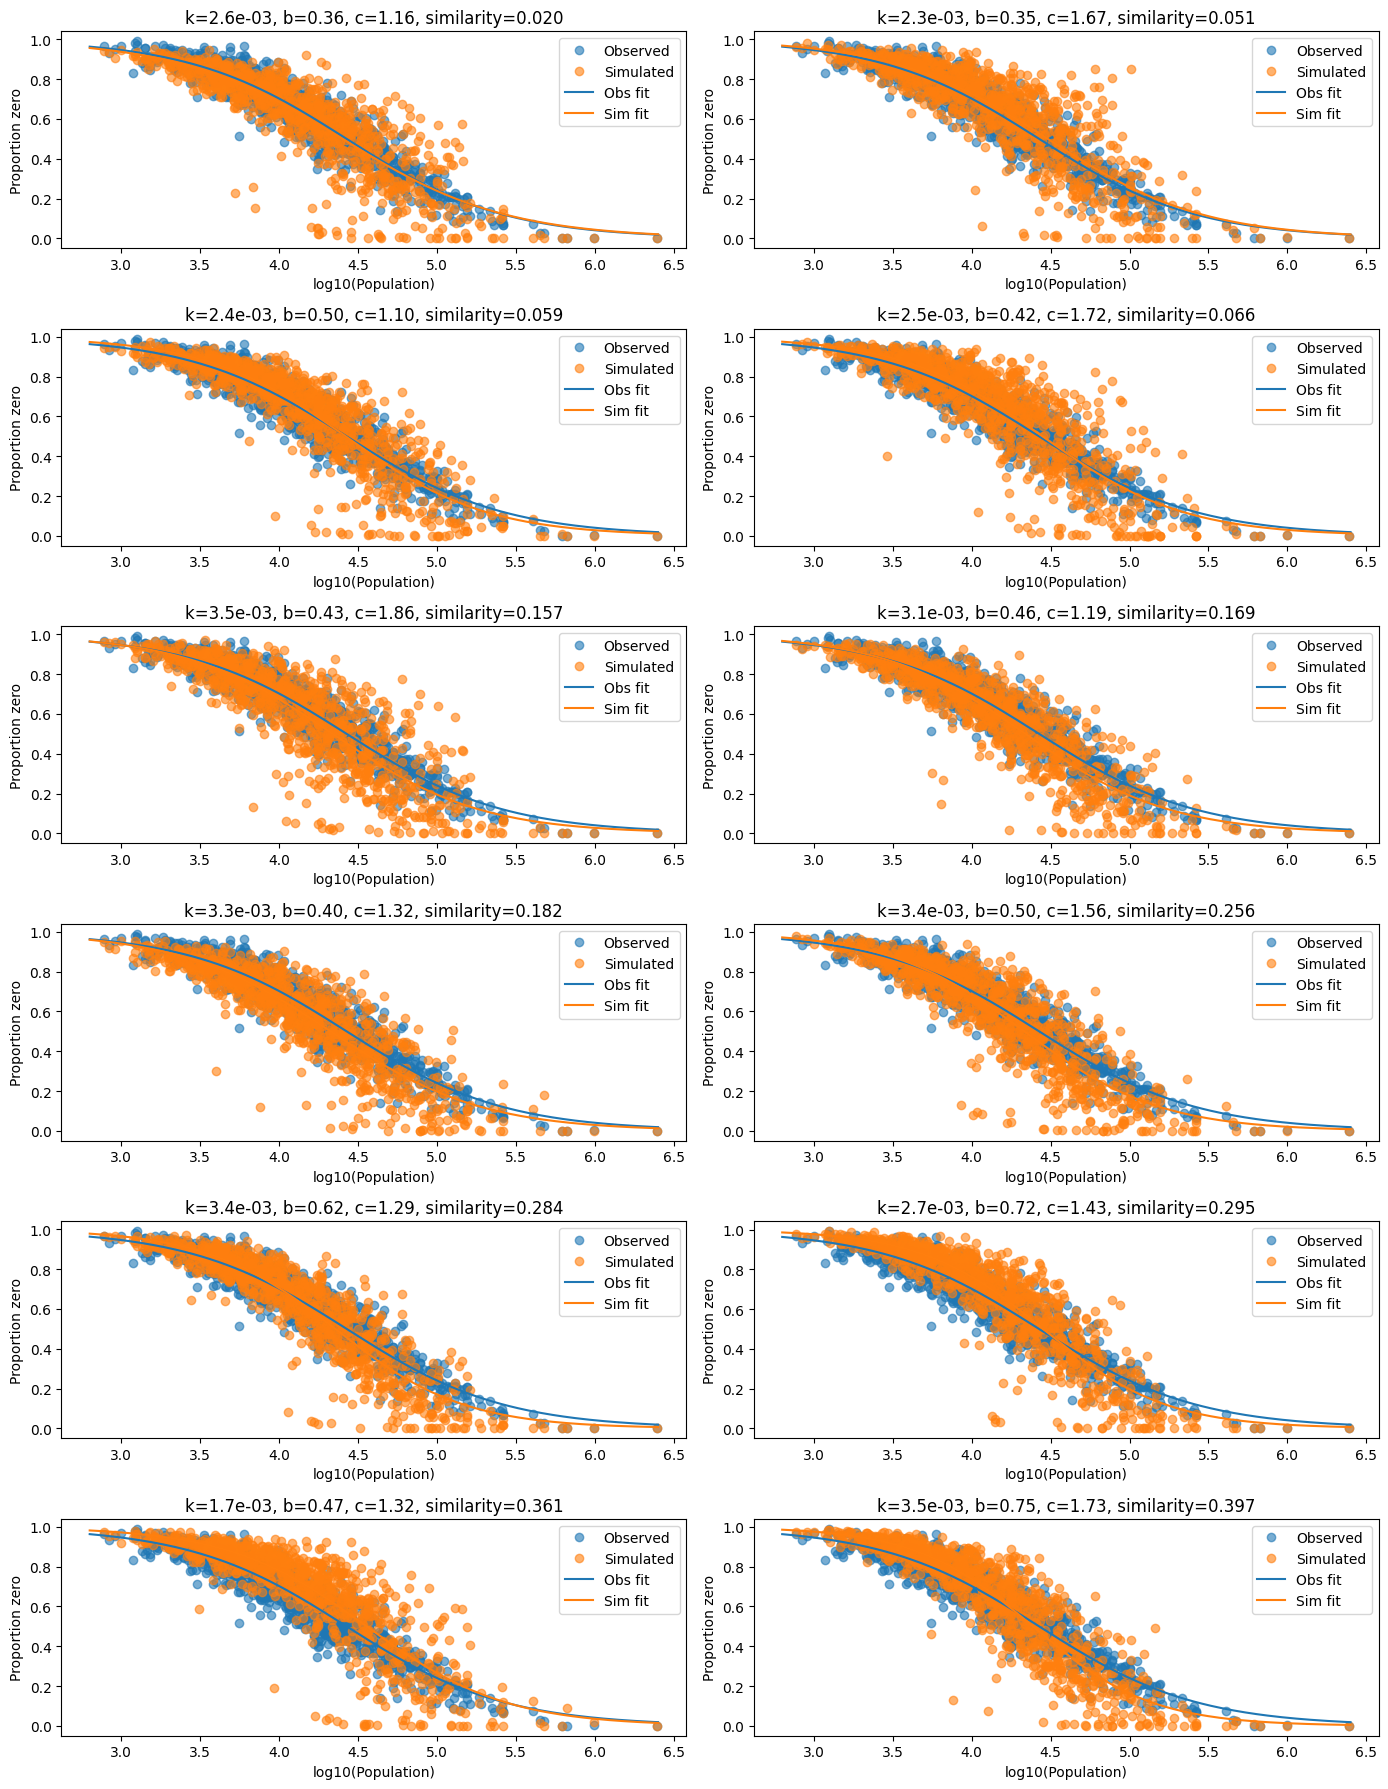

In [14]:
fig, axes = plt.subplots(6, 2, figsize=(14, 18))
axes = axes.flatten()

for idx in range(12):
    # Get the parameter set with the idx-th lowest similarity
    k_best, b_best, c_best = ranked_params.loc[idx, ["k", "b", "c"]]
    sim_score = ranked_params.loc[idx, "similarity"]
    # Find the corresponding result DataFrame
    for df in results:
        if np.isclose(df["k"].iloc[0], k_best) and np.isclose(df["b"].iloc[0], b_best) and np.isclose(df["c"].iloc[0], c_best):
            df_best = df
            break

    logpop_sim = np.log10(df_best["population"])
    prop_zero_sim = df_best["prop_zero"]

    # Fit logistic to simulation
    popt_sim = fit_mean_var(logpop_sim, prop_zero_sim)
    # Fit logistic to observed (reuse from above)
    popt_obs = fit_mean_var(np.log10(EWdata["population"]), EWdata["prop_zero"])

    xfit = np.linspace(2.8, 6.4, 200)
    axes[idx].plot(np.log10(EWdata["population"]), EWdata["prop_zero"], "o", label="Observed", alpha=0.6)
    axes[idx].plot(logpop_sim, prop_zero_sim, "o", label="Simulated", alpha=0.6)
    axes[idx].plot(xfit, logistic(xfit, *popt_obs), "-", label="Obs fit", color="C0")
    axes[idx].plot(xfit, logistic(xfit, *popt_sim), "-", label="Sim fit", color="C1")
    axes[idx].set_title(f"k={k_best:.1e}, b={b_best:.2f}, c={c_best:.2f}, similarity={sim_score:.3f}")
    axes[idx].set_xlabel("log10(Population)")
    axes[idx].set_ylabel("Proportion zero")
    axes[idx].legend()

plt.tight_layout()
plt.show()

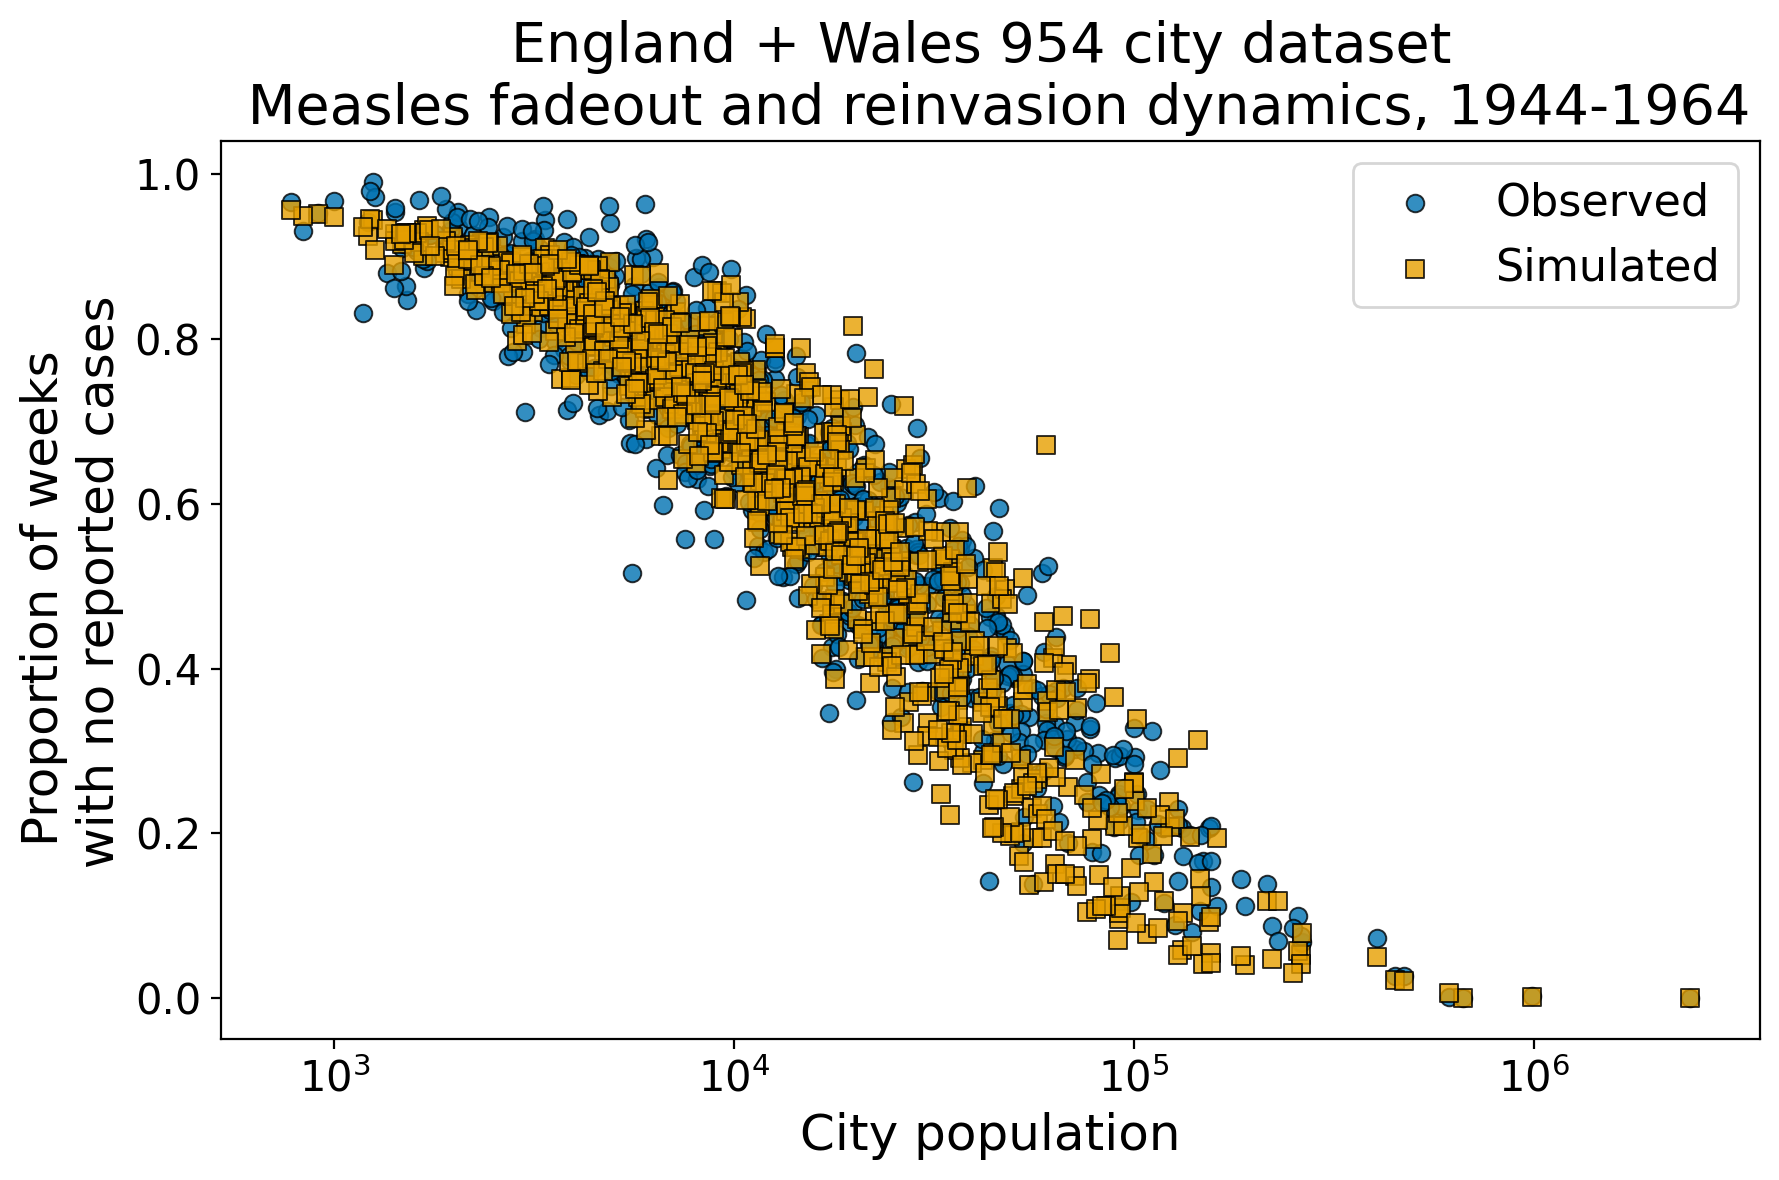

In [15]:
# Find the top 10 best simulations (lowest similarity)
top10 = ranked_params.iloc[:10]

# Collect the corresponding result DataFrames
df_top10 = []
for idx, row in top10.iterrows():
    k_best, b_best, c_best = row[["k", "b", "c"]]
    for df in results:
        if np.isclose(df["k"].iloc[0], k_best) and np.isclose(df["b"].iloc[0], b_best) and np.isclose(df["c"].iloc[0], c_best):
            df_top10.append(df)
            break

# Stack prop_zero and population for averaging
populations = np.stack([np.log10(df["population"].values) for df in df_top10])
prop_zeros = np.stack([df["prop_zero"].values for df in df_top10])

# Compute mean and std across the top 10
logpop_sim_mean = populations.mean(axis=0)
prop_zero_sim_mean = prop_zeros.mean(axis=0)
prop_zero_sim_std = prop_zeros.std(axis=0)

logpop_obs = np.log10(EWdata["population"])
prop_zero_obs = EWdata["prop_zero"]
# logpop_sim = np.log10(df_best['population'])
# prop_zero_sim = df_best['prop_zero']

plt.figure(figsize=(9, 6), dpi=200)
# Use colorblind-friendly colors (e.g., from Color Universal Design palette)
# Blue: #0072B2, Orange: #E69F00
plt.scatter(logpop_obs, prop_zero_obs, s=40, color="#0072B2", label="Observed", alpha=0.8, edgecolor="k", linewidth=0.7)
plt.scatter(
    logpop_sim_mean, prop_zero_sim_mean, s=40, color="#E69F00", label="Simulated", alpha=0.8, marker="s", edgecolor="k", linewidth=0.7
)

plt.xlabel("City population", fontsize=18)
plt.ylabel("Proportion of weeks \n with no reported cases", fontsize=18)
plt.title("England + Wales 954 city dataset \n Measles fadeout and reinvasion dynamics, 1944-1964", fontsize=20)
plt.legend(fontsize=16)
# Set custom x-ticks and labels for log10 scale
xticks = [3, 4, 5, 6]
xticklabels = [r"$10^{%g}$" % x for x in xticks]
plt.xticks(xticks, xticklabels, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Cities in England & Wales\nMarker size ~ log10(population)')

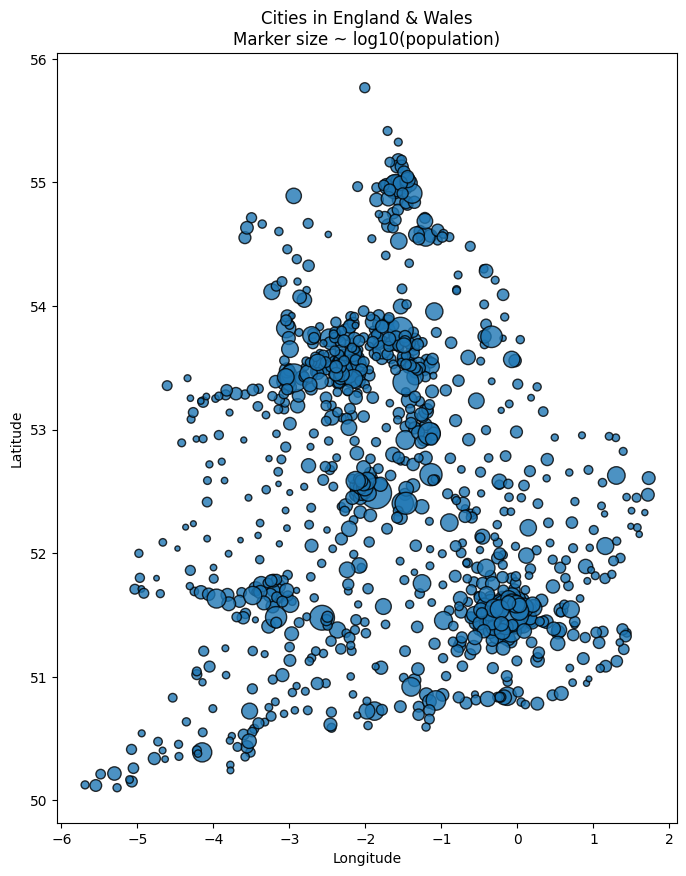

In [551]:
# Plot spatial distribution of cities with marker size proportional to log(population)
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))

# Scatter plot: marker size proportional to log(population)
sizes = 0.5 * np.sqrt(EWdata["population"])  # adjust scaling as needed
sc = ax.scatter(EWdata["longitude"], EWdata["latitude"], s=sizes, alpha=0.8, c="C0", edgecolor="k", linewidth=1.0)

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Cities in England & Wales\nMarker size ~ log10(population)")

# # Optional: Add England & Wales borders using geopandas if available
# try:
#     # Plot England & Wales borders from local shapefile
#     shapefile_path = os.path.join('..', 'ne_110m_admin_0_map_units', 'ne_110m_admin_0_map_units.shp')
#     borders = gpd.read_file(shapefile_path)
#     # Filter for United Kingdom, then further for England and Wales if possible
#     uk = borders[borders['SOVEREIGNT'] == 'United Kingdom']
#     # If there are subregions, filter for England and Wales
#     if 'NAME' in uk.columns:
#         england_wales = uk[uk['NAME'].isin(['England', 'Wales'])]
#         if not england_wales.empty:
#             england_wales.boundary.plot(ax=ax, color='k', linewidth=1)
#         else:
#             uk.boundary.plot(ax=ax, color='k', linewidth=1)
#     else:
#         uk.boundary.plot(ax=ax, color='k', linewidth=1)
# except ImportError:
#     print("geopandas not installed, skipping borders.")
# except Exception as e:
#     print(f"Could not plot borders: {e}")

In [552]:
np.max(sizes)

784.6177413237608

In [553]:
borders

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
0,Admin-0 map unit,1,6,Fiji,FJI,0,2,Sovereign country,1,Fiji,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,Admin-0 map unit,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,1,United Republic of Tanzania,...,None,None,None,None,None,None,None,None,None,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,Admin-0 map unit,1,7,Western Sahara,SAH,0,2,Indeterminate,1,Western Sahara,...,Unrecognized,Unrecognized,Unrecognized,None,None,Unrecognized,None,None,None,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 map unit,1,2,Canada,CAN,0,2,Sovereign country,1,Canada,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,Admin-0 map unit,1,2,United States of America,US1,1,2,Country,1,United States of America,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,Admin-0 map unit,1,6,Kosovo,KOS,0,2,Disputed,1,Kosovo,...,Admin-0 country,Unrecognized,Admin-0 country,Unrecognized,Admin-0 country,Admin-0 country,Admin-0 country,Admin-0 country,Unrecognized,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
179,Admin-0 map unit,1,5,Trinidad and Tobago,TTO,0,2,Sovereign country,1,Trinidad and Tobago,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-61.68 10.76, -61.105 10.89, -60.895..."
180,Admin-0 map unit,1,5,United Kingdom,GB1,1,3,Geo unit,1,United Kingdom,...,Admin-1 region,None,Admin-1 region,Admin-1 region,Admin-1 region,Admin-1 region,Admin-1 region,None,Admin-1 region,"POLYGON ((-3.09383 53.40455, -2.72382 52.93506..."
181,Admin-0 map unit,1,5,United Kingdom,GB1,1,3,Geo unit,1,United Kingdom,...,Admin-1 region,None,Admin-1 region,Admin-1 region,Admin-1 region,Admin-1 region,Admin-1 region,None,Admin-1 region,"POLYGON ((-2.00568 55.8049, -2.22872 55.6686, ..."


In [16]:
# wavelet phase analysis
import pywt


def pad_data(x):
    """
    Pad data to the next power of 2
    """
    nx = len(x)  # number of samples
    nx2 = (2 ** np.ceil(np.log(nx) / np.log(2))).astype(int)  # next power of 2
    x2 = np.zeros(nx2, dtype=x.dtype)  # pad to next power of 2
    offset = (nx2 - nx) // 2  # offset
    x2[offset : (offset + nx)] = x  # copy
    return x2


def log_transform(x, debug=1):
    """
    Log transform for case data
    """
    # add one and take log
    x = np.log(x + 1)
    # set mean=0 and std=1
    m = np.mean(x)
    s = np.std(x)
    x = (x - m) / s
    return x


def calc_Ws(cases):
    # transform case data
    log_cases = pad_data(log_transform(cases))

    # setup and execute wavelet transform
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#morlet-wavelet
    wavelet = pywt.ContinuousWavelet("cmor2-1")

    dt = 1  # 2 weeks
    widths = np.logspace(np.log10(1), np.log10(7 * 52), int(7 * 52))
    [cwt, frequencies] = pywt.cwt(log_cases, widths, wavelet, dt)

    # Number of time steps in padded time series
    nt = len(cases)
    # trim matrix
    offset = (cwt.shape[1] - nt) // 2
    cwt = cwt[:, offset : offset + nt]

    return cwt, frequencies

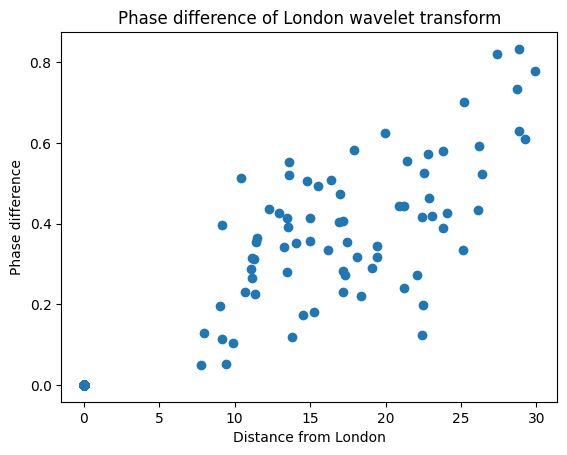

In [17]:
# Get the cases for London from EWdata
london_idx = EWdata[EWdata["name"].str.contains("London", case=False)].index[0]
london_cases = EWdata[EWdata["name"].str.contains("London", case=False)]["cases"].iloc[0]
ref_cwt, frequencies = calc_Ws(np.array(london_cases.flatten()))
distances_from_london = distances[london_idx, :]

x = np.zeros(len(EWdata))
y = np.zeros(len(EWdata))
y2 = np.zeros(len(EWdata))
for i, row in EWdata.iterrows():
    if distances_from_london[i] > 30:
        continue
    cwt, frequencies = calc_Ws(row["cases"].flatten())
    diff = ref_cwt * np.conj(cwt)
    ind = np.where(np.logical_and(frequencies < 1 / (1.5 * 52), frequencies > 1 / (3 * 52)))
    diff1 = diff[ind[0], :]
    x[i] = distances_from_london[i]
    y[i] = np.angle(np.mean(diff1))
    ind2 = np.where(np.logical_and(frequencies < 1 / (0.75 * 52), frequencies > 1 / (1.25 * 52)))
    diff2 = diff[ind2[0], :]
    y2[i] = np.angle(np.mean(diff2))

plt.plot(x, y, "o")
plt.xlabel("Distance from London")
plt.ylabel("Phase difference")
plt.title("Phase difference of London wavelet transform")
plt.show()

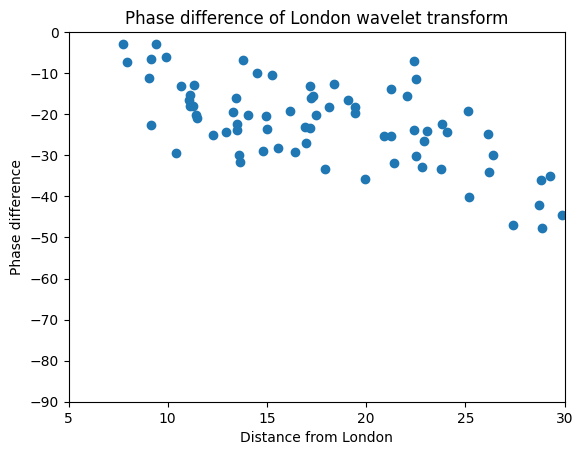

In [18]:
plt.plot(x, -y * 180 / np.pi, "o")
plt.xlim(5, 30)
plt.ylim(-90, 0)
plt.xlabel("Distance from London")
plt.ylabel("Phase difference")
plt.title("Phase difference of London wavelet transform")
plt.show()

In [557]:
len(results)

100

In [558]:
# Get the cases for London from EWdata
# For each simulation in results, compute phase difference arrays y_sim and y2_sim
phase_diff_results = []

london_idx = EWdata[EWdata["name"].str.contains("London", case=False)].index[0]
distances_from_london = distances[london_idx, :]

for sim_idx, df_sim in enumerate(results):
    # Get London cases for this simulation
    london_cases_sim = df_sim[df_sim["name"].str.contains("London", case=False)]["cases"].iloc[0]
    ref_cwt_sim, frequencies_sim = calc_Ws(np.array(london_cases_sim[520:]).flatten())
    x_sim = np.zeros(len(df_sim))
    y_sim = np.zeros(len(df_sim))
    y2_sim = np.zeros(len(df_sim))
    for i, row in df_sim.iterrows():
        if distances_from_london[i] > 30:
            continue
        cwt_sim, frequencies_sim = calc_Ws(np.array(row["cases"][520:]).flatten())
        diff_sim = ref_cwt_sim * np.conj(cwt_sim)
        ind = np.where(np.logical_and(frequencies_sim < 1 / (1.5 * 52), frequencies_sim > 1 / (3 * 52)))
        diff1_sim = diff_sim[ind[0], :]
        x_sim[i] = distances_from_london[i]
        y_sim[i] = np.angle(np.mean(diff1_sim))
        ind2 = np.where(np.logical_and(frequencies_sim < 1 / (0.75 * 52), frequencies_sim > 1 / (1.25 * 52)))
        diff2_sim = diff_sim[ind2[0], :]
        y2_sim[i] = np.angle(np.mean(diff2_sim))
    phase_diff_results.append({"sim_idx": sim_idx, "x": x_sim, "y": y_sim, "y2": y2_sim})

In [559]:
with open(os.path.join(output_dir, "phase_diff_results2.pkl"), "wb") as f:
    pickle.dump(phase_diff_results, f)

In [19]:
with open(os.path.join(output_dir, "phase_diff_results2.pkl"), "rb") as f:
    phase_diff_results = pickle.load(f)

In [420]:
params_df

,k,b,c,similarity
0,0.010715,0.390482,1.986225,3.380539
1,0.002402,0.504796,1.104515,0.058813
2,0.006794,0.681441,1.422656,1.920747
3,0.008658,0.795398,1.875062,2.041468
4,0.022042,0.336826,1.584276,8.052248
5,0.003502,0.367376,1.017534,0.453346
6,0.009043,0.670022,1.888703,2.365157
7,0.001937,0.716891,1.384148,0.578412
8,0.005581,0.344386,1.167730,2.021110
9,0.001878,0.714709,1.337180,0.614229


In [1]:
for ind in range(100):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Left plot: Phase difference
    axs[0].plot(x, -y * 180 / np.pi, "o", label="Observed")
    axs[0].plot(phase_diff_results[14]["x"], -phase_diff_results[ind]["y"] * 180 / np.pi, "o", label="Simulated")
    axs[0].set_xlim(5, 30)
    axs[0].set_ylim(-90, 90)
    axs[0].set_xlabel("Distance from London")
    axs[0].set_ylabel("Phase difference")
    axs[0].set_title("Phase difference of London wavelet transform")
    axs[0].legend()

    # Right plot: Proportion zero vs log10(population)
    axs[1].plot(np.log10(EWdata["population"]), EWdata["prop_zero"], "o", label="Observed", alpha=0.6)
    axs[1].plot(np.log10(results[10]["population"]), results[ind]["prop_low"], ".", label="Simulated")
    axs[1].set_xlabel("log10(Population)")
    axs[1].set_ylabel("Proportion zero")
    axs[1].set_title("Proportion zero vs log10(Population)")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

NameError: name 'plt' is not defined

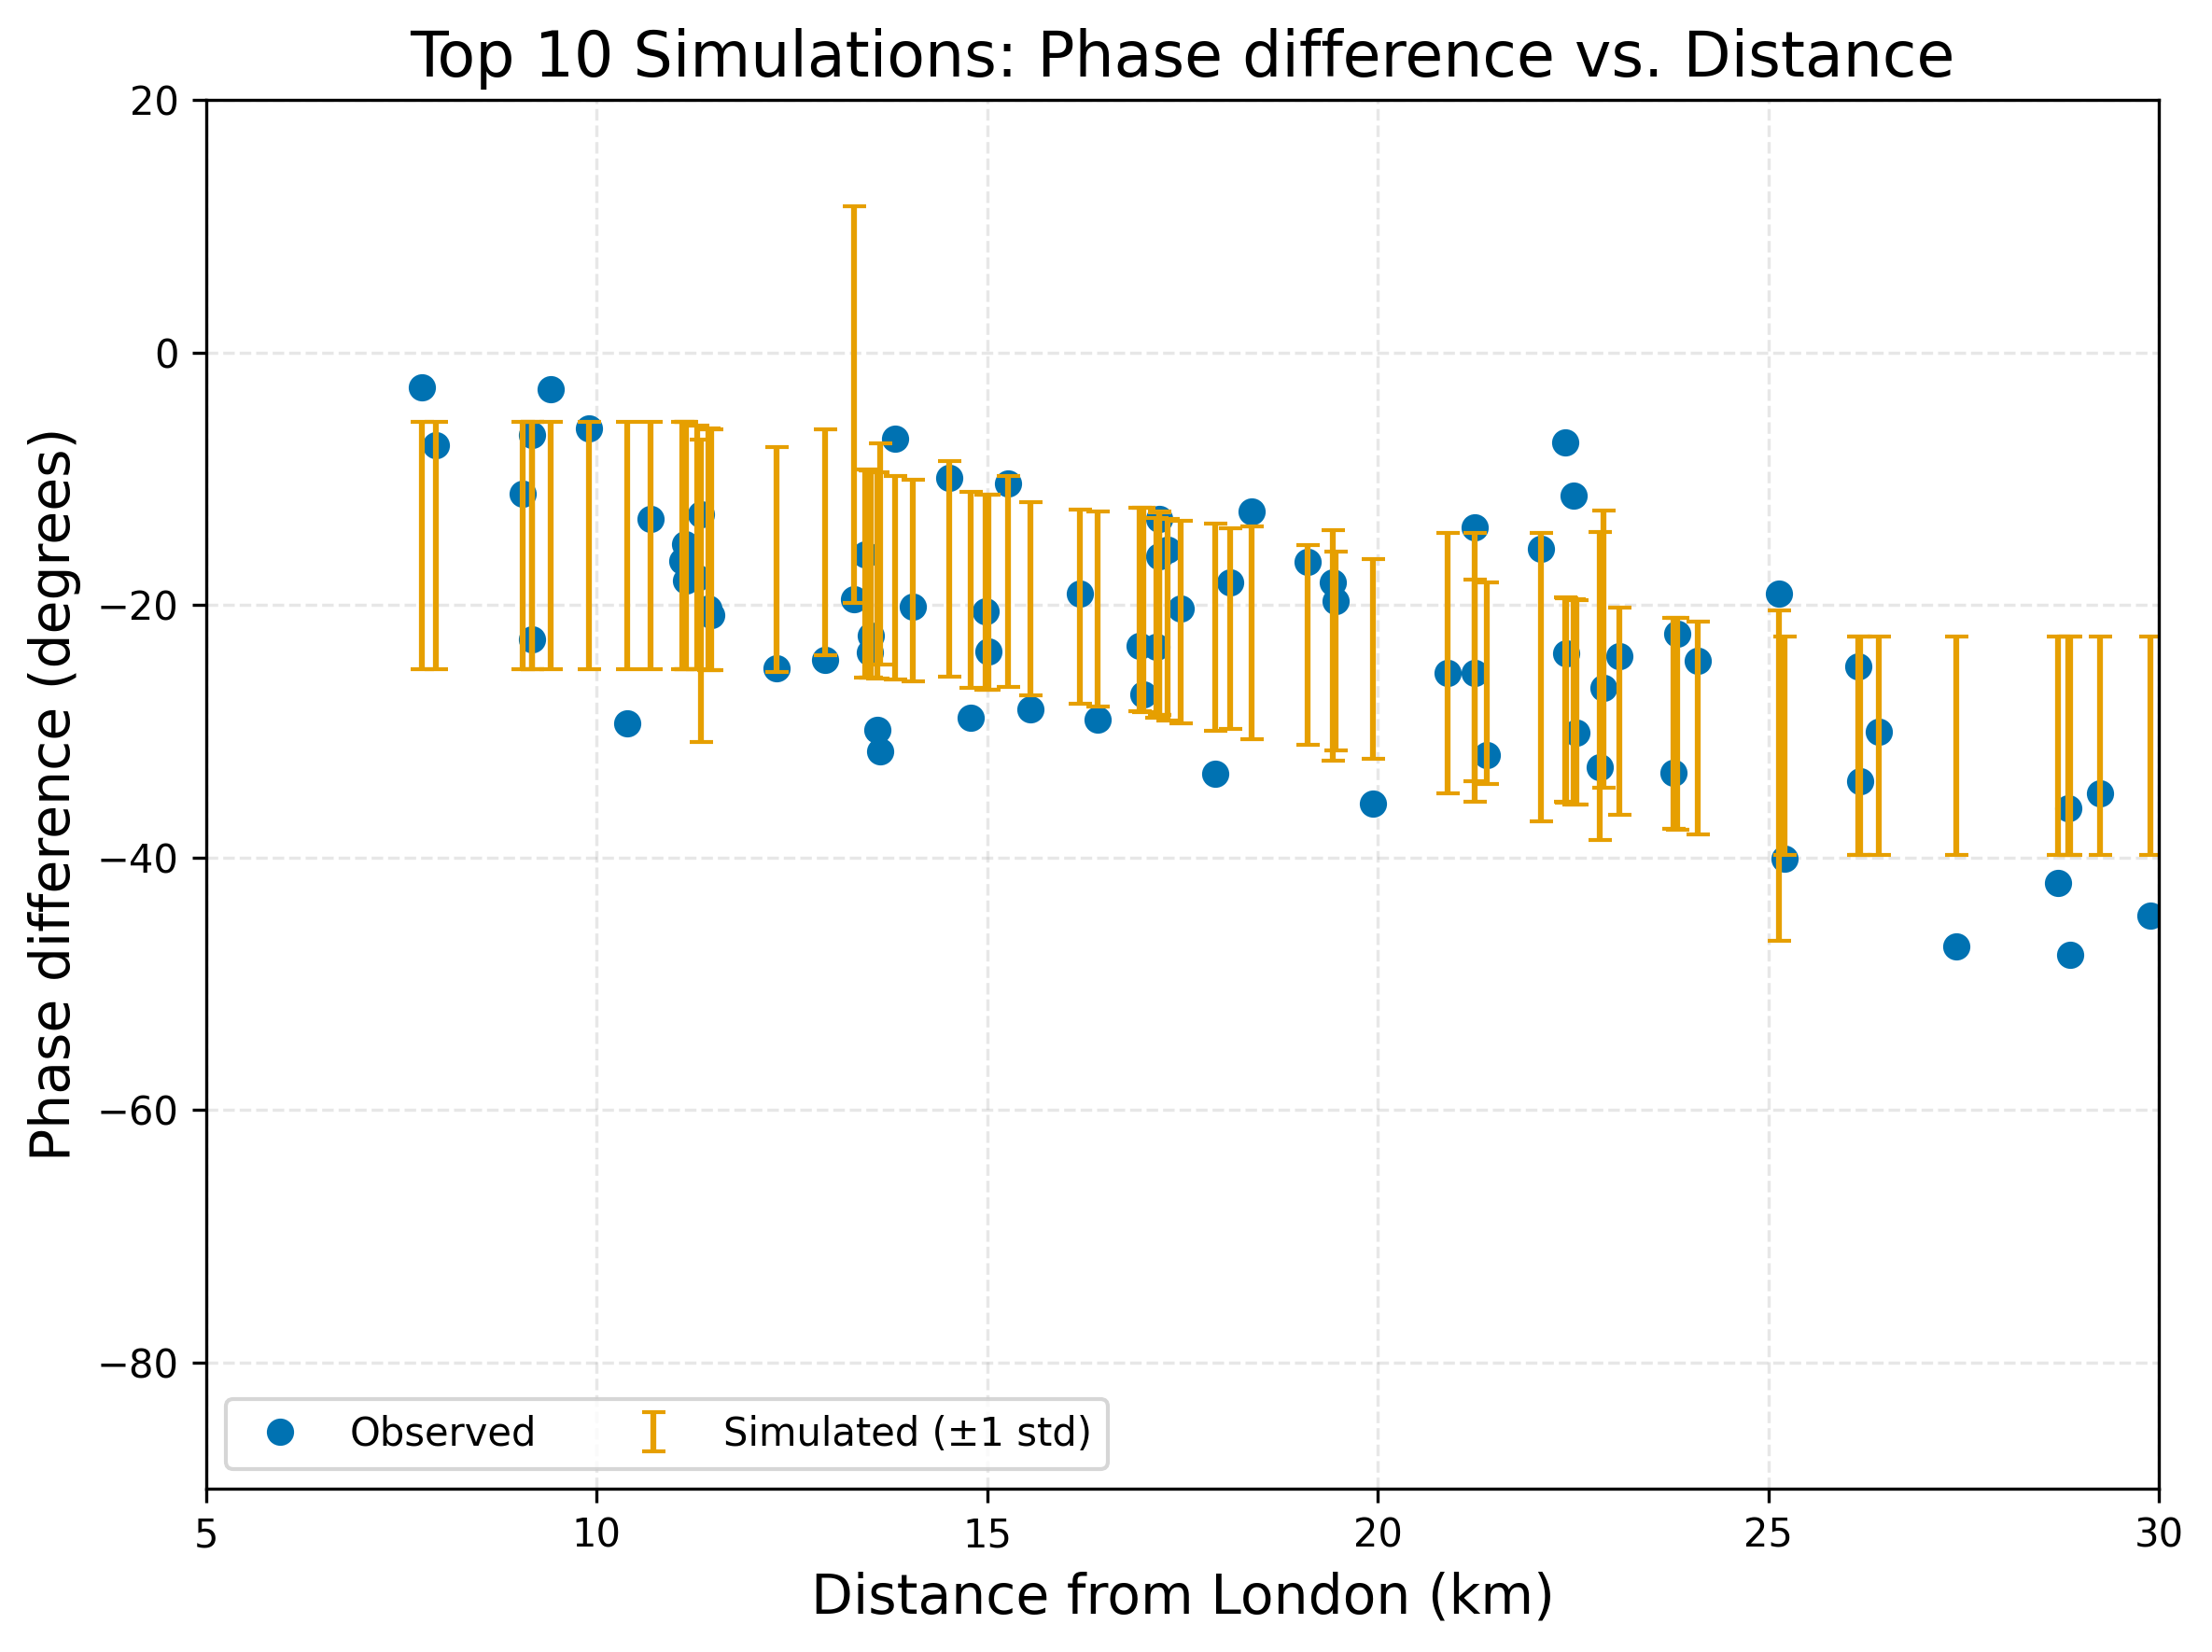

In [31]:
# 1. Compute similarity between observed and each simulation's phase difference curve
# We'll use the y (phase difference) vs x (distance) arrays

# Only consider cities within 5-30 km (as in previous plots)
mask = (x >= 5) & (x <= 30)
x_obs = x[mask]
y_obs = y[mask]

sim_scores = []
for sim in phase_diff_results:
    x_sim = sim["x"]
    y_sim = sim["y"]
    # Interpolate simulation phase difference to observed x values for fair comparison
    mask_sim = (x_sim >= 5) & (x_sim <= 30)
    if np.sum(mask_sim) < 5:  # skip if not enough points
        sim_scores.append(np.inf)
        continue
    # Interpolate simulation y to observed x points
    try:
        y_sim_interp = np.interp(x_obs, x_sim[mask_sim], y_sim[mask_sim])
        score = np.sum((y_obs - y_sim_interp) ** 2)
    except Exception:
        score = np.inf
    sim_scores.append(score)

# 2. Get indices of the 10 best simulations (lowest scores)
top10_idx = np.argsort(sim_scores)[:10]

# 3. Plot
plt.figure(figsize=(8, 6), dpi=300)
plt.plot(x_obs, -y_obs * 180 / np.pi, "o", color="#0072B2", label="Observed", linewidth=2, markersize=6)

# Color palette for simulations
import matplotlib.cm as cm

colors = cm.viridis(np.linspace(0, 1, 10))
# Average the top 10 simulations' phase difference curves (interpolated to observed x points)
y_sims_interp = []
for idx in top10_idx:
    sim = phase_diff_results[idx]
    x_sim = sim["x"]
    y_sim = sim["y"]
    mask_sim = (x_sim >= 5) & (x_sim <= 30)
    if np.sum(mask_sim) < 5:
        continue
    y_interp = np.interp(x_obs, x_sim[mask_sim], y_sim[mask_sim])
    y_sims_interp.append(y_interp)
y_sims_interp = np.array(y_sims_interp)
y_sim_mean = np.mean(y_sims_interp, axis=0)
y_sim_std = np.std(y_sims_interp, axis=0)

# plt.plot(x_obs, -y_sim_mean*180/np.pi, 'o', color='#E69F00', linewidth=2.5, label='Simulated (mean)')
plt.errorbar(
    x_obs,
    -y_sim_mean * 180 / np.pi,
    yerr=y_sim_std * 180 / np.pi,
    marker="s",
    fmt="none",
    ecolor="#E69F00",
    capsize=3,
    label="Simulated (±1 std)",
)

plt.xlim(5, 30)
plt.ylim(-90, 20)
plt.xlabel("Distance from London (km)", fontsize=14)
plt.ylabel("Phase difference (degrees)", fontsize=14)
plt.title("Top 10 Simulations: Phase difference vs. Distance", fontsize=16)
plt.legend(fontsize=10, loc="lower left", ncol=2, frameon=True)
plt.tight_layout()
plt.grid(True, linestyle="--", alpha=0.3)
plt.show()

In [215]:
# Compute the total cases across all towns for each simulation in results
total_cases_per_sim = []

for df in results:
    # Each row's "cases" is a list/array of weekly cases for that town
    # Stack all towns' cases into a 2D array: shape (num_towns, num_weeks)
    cases_matrix = np.stack(df["incidence"].values)
    # Sum across towns (axis=0) to get total cases per week
    total_cases = cases_matrix.sum(axis=0)
    total_cases_per_sim.append(total_cases)

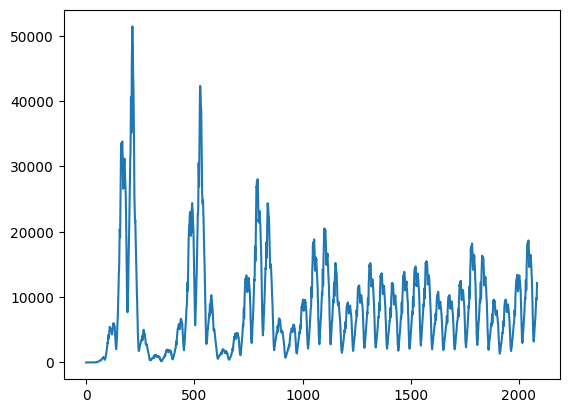

In [256]:
plt.plot(total_cases_per_sim[39], label="Sim 1")

array([11.88012594,  8.31229433, 10.85563527, 10.57641161,  9.2228055 ,
        9.36700327, 11.23874575, 11.88074165, 12.83542124,  9.96101557,
       12.30378732,  9.5047228 ,  9.48869867, 10.24404794,  8.29039734,
       11.9094614 , 12.61633063,  9.60087498, 10.69194959, 10.79435719])